In [1]:
# YOLOv8 설치 및 모델 준비
!pip install -q ultralytics
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt



In [2]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/nanum: skipping, looped dire

In [3]:
#  간단 실행 버전 - YOLO 다중 객체 탐지

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import requests
import os
import time

import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def download_diverse_images():
    """다양한 이미지 자동 다운로드"""

    # 훨씬 더 다양한 이미지 URL들
    image_urls = [
        # 기본 테스트 이미지들
        'https://ultralytics.com/images/bus.jpg',
        'https://ultralytics.com/images/zidane.jpg',
        'https://raw.githubusercontent.com/ultralytics/yolov5/master/data/images/bus.jpg',

        # 사람과 다양한 활동
        'https://images.unsplash.com/photo-1511632765486-a01980e01a18?w=800',  #
        'https://images.unsplash.com/photo-1571019613454-1cb2f99b2d8b?w=800',  #
        'https://images.unsplash.com/photo-1544725176-7c40e5a71c5e?w=800',   #

        # 교통/차량과 사람
        'https://images.unsplash.com/photo-1449824913935-59a10b8d2000?w=800',  #
        'https://images.unsplash.com/photo-1502920917128-1aa500764cbd?w=800',  #
        'https://images.unsplash.com/photo-1538991383142-36c4edeaffde?w=800',  #

        # 스포츠 장면
        'https://images.unsplash.com/photo-1551698618-1dfe5d97d256?w=800',   #
        'https://images.unsplash.com/photo-1606107557195-0e29a4b5b4aa?w=800', #

        # 일상 생활
        'https://images.unsplash.com/photo-1542909168-82c3e7fdca5c?w=800',   #
        'https://images.unsplash.com/photo-1513475382585-d06e58bcb0e0?w=800', #
        'https://images.unsplash.com/photo-1434494878577-86c23bcb06b9?w=800', #

        # 사람과 동물
        'https://images.unsplash.com/photo-1552053831-71594a27632d?w=800',   #
        'https://images.unsplash.com/photo-1583337130417-3346a1be7dee?w=800', #
    ]

    print(f" {len(image_urls)}개 이미지 다운로드 시작...")

    downloaded_files = []

    for i, url in enumerate(image_urls):
        try:
            print(f"   {i+1}/{len(image_urls)}: 다운로드 중...")

            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
            }

            response = requests.get(url, headers=headers, timeout=10, stream=True)

            if response.status_code == 200:
                filename = f'sample_{i:02d}.jpg'

                with open(filename, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)

                # 파일 크기 확인
                if os.path.getsize(filename) > 5000:  # 5KB 이상
                    downloaded_files.append(filename)
                    print(f"       성공: {filename}")
                else:
                    os.remove(filename)
                    print(f"       파일이 너무 작음")
            else:
                print(f"       HTTP {response.status_code}")

        except Exception as e:
            print(f"       오류: {str(e)[:30]}...")
            continue

        time.sleep(0.3)  # 서버 부하 방지

    print(f"\n 총 {len(downloaded_files)}개 이미지 다운로드 완료!")
    return downloaded_files

def analyze_images_simple():
    """간단한 이미지 분석"""

    # YOLO 모델 로드
    print(" YOLO 모델 로딩...")
    model = YOLO('yolov8n.pt')
    print(" 모델 로드 완료!")

    # 이미지 다운로드
    image_files = download_diverse_images()

    if not image_files:
        print(" 다운로드된 이미지가 없습니다.")
        return

    # 찾을 객체 조합들 정의
    target_combinations = {
        '사람+차량': (['person'], ['car', 'truck', 'bus', 'motorcycle', 'bicycle']),
        '사람+동물': (['person'], ['dog', 'cat', 'horse', 'bird']),
        '사람+스포츠': (['person'], ['sports ball', 'tennis racket', 'baseball bat', 'frisbee']),
        '사람+소지품': (['person'], ['backpack', 'handbag', 'suitcase', 'umbrella', 'tie']),
        '사람+전자기기': (['person'], ['cell phone', 'laptop', 'tv', 'remote']),
    }

    print(f"\n {len(image_files)}개 이미지 분석 시작...")

    matches = []

    for img_file in image_files:
        # 이미지 읽기
        img = cv2.imread(img_file)
        if img is None:
            print(f" {img_file}: 읽기 실패")
            continue

        # YOLO 탐지
        results = model(img_file)

        # 탐지된 객체들 수집
        detected_classes = []
        for r in results:
            if r.boxes is not None:
                for cls in r.boxes.cls.cpu().numpy():
                    class_name = model.names[int(cls)]
                    detected_classes.append(class_name)

        detected_classes = list(set(detected_classes))  # 중복 제거

        if not detected_classes:
            print(f" {img_file}: 객체 없음")
            continue

        print(f" {img_file}: {detected_classes}")

        # 조합 매칭 확인
        matched_combos = []
        for combo_name, (primary, secondary) in target_combinations.items():
            primary_found = any(obj in detected_classes for obj in primary)
            secondary_found = any(obj in detected_classes for obj in secondary)

            if primary_found and secondary_found:
                matched_combos.append(combo_name)

        if matched_combos:
            print(f"    매치: {matched_combos}")
            matches.append({
                'file': img_file,
                'image': img,
                'detected': detected_classes,
                'combos': matched_combos,
                'results': results
            })
        else:
            print(f"    매치 없음")

    # 결과 시각화
    if matches:
        print(f"\n {len(matches)}개 매치된 이미지 표시")

        # 그리드 계산
        n = len(matches)
        cols = min(3, n)
        rows = (n + cols - 1) // cols

        plt.figure(figsize=(15, 5 * rows))

        for i, match in enumerate(matches):
            plt.subplot(rows, cols, i + 1)

            # 이미지 표시
            img_rgb = cv2.cvtColor(match['image'], cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)

            # 제목
            title = f"{match['file']}\n{' | '.join(match['combos'])}"
            plt.title(title, fontsize=10)
            plt.axis('off')

            # 탐지된 객체 정보
            detected_text = f"탐지: {', '.join(match['detected'][:5])}"
            if len(match['detected']) > 5:
                detected_text += "..."
            plt.xlabel(detected_text, fontsize=8)

        plt.tight_layout()
        plt.show()

        # 요약 출력
        print(f"\n 분석 결과 요약:")
        print(f"   • 총 분석 이미지: {len(image_files)}개")
        print(f"   • 조건 만족 이미지: {len(matches)}개")

        combo_counts = {}
        for match in matches:
            for combo in match['combos']:
                combo_counts[combo] = combo_counts.get(combo, 0) + 1

        print(f"   • 조합별 매치:")
        for combo, count in combo_counts.items():
            print(f"     - {combo}: {count}개")

    else:
        print("\n 조건에 맞는 이미지를 찾지 못했습니다.")
        print("더 많은 이미지를 시도하거나 다른 조합을 사용해보세요.")

# 실행 함수들
def quick_run():
    """빠른 실행"""
    print(" YOLO 다중 객체 탐지 - 빠른 실행")
    print("=" * 40)
    analyze_images_simple()

def custom_urls_test():
    """사용자 정의 URL로 테스트"""
    print(" 사용자 정의 URL 테스트")

    custom_urls = [
        'https://your-custom-url-1.jpg',
        'https://your-custom-url-2.jpg',
        # 여기에 원하는 URL들 추가
    ]

    print(" custom_urls 리스트에 원하는 이미지 URL들을 추가하고 실행하세요!")





 YOLO 다중 객체 탐지 - 빠른 실행
 YOLO 모델 로딩...
 모델 로드 완료!
 16개 이미지 다운로드 시작...
   1/16: 다운로드 중...
       성공: sample_00.jpg
   2/16: 다운로드 중...
       성공: sample_01.jpg
   3/16: 다운로드 중...
       성공: sample_02.jpg
   4/16: 다운로드 중...
       성공: sample_03.jpg
   5/16: 다운로드 중...
       성공: sample_04.jpg
   6/16: 다운로드 중...
       성공: sample_05.jpg
   7/16: 다운로드 중...
       성공: sample_06.jpg
   8/16: 다운로드 중...
       성공: sample_07.jpg
   9/16: 다운로드 중...
       성공: sample_08.jpg
   10/16: 다운로드 중...
       성공: sample_09.jpg
   11/16: 다운로드 중...
       성공: sample_10.jpg
   12/16: 다운로드 중...
       성공: sample_11.jpg
   13/16: 다운로드 중...
       성공: sample_12.jpg
   14/16: 다운로드 중...
       성공: sample_13.jpg
   15/16: 다운로드 중...
       성공: sample_14.jpg
   16/16: 다운로드 중...
       성공: sample_15.jpg

 총 16개 이미지 다운로드 완료!

 16개 이미지 분석 시작...

image 1/1 /content/sample_00.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 190.8ms
Speed: 6.6ms preprocess, 190.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


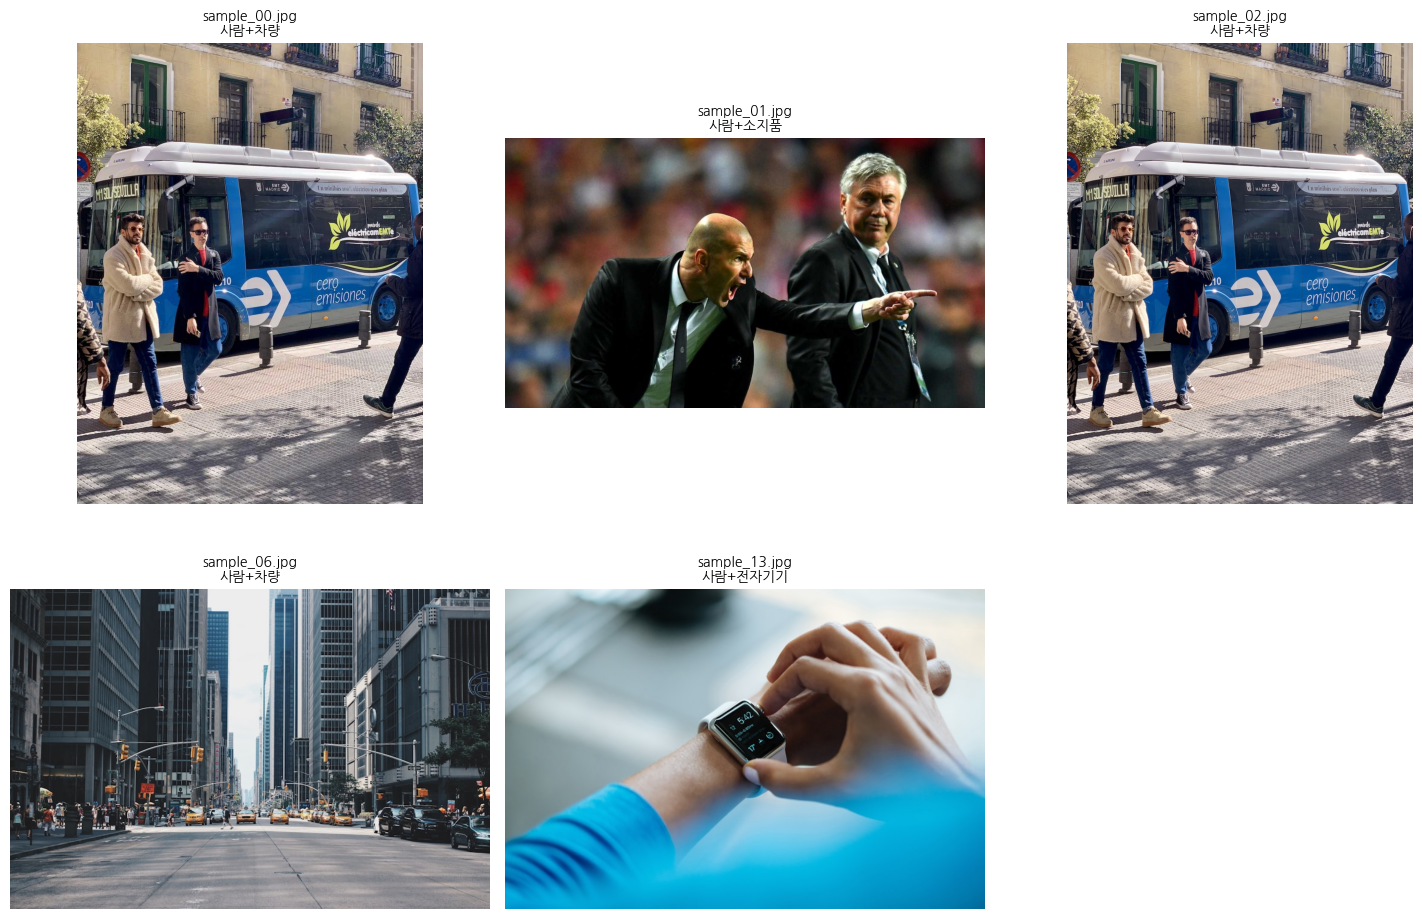


 분석 결과 요약:
   • 총 분석 이미지: 16개
   • 조건 만족 이미지: 5개
   • 조합별 매치:
     - 사람+차량: 3개
     - 사람+소지품: 1개
     - 사람+전자기기: 1개


In [4]:
 quick_run()